In this notebook, we will train an object detection model to predict rotated bounding boxes.

Specifically, we are going to adapt the anchorless, one-stage object detection model architecture FCOS:
* [Tian et al., FCOS: Fully Convolutional One-Stage Object Detection. **2019**](https://arxiv.org/pdf/1904.01355.pdf)

to predict these rotated bounding boxes. As a loss function, we are using the Kullback-Leibler divergence for learning the rotated bounding box parameters as suggested by Yang et al.:
* [Yang et al., Learning High-Precision Bounding Box for Rotated Object Detection via Kullback-Leibler Divergence. **2021**](https://arxiv.org/pdf/2106.01883.pdf).

We will be working with *Face Detection Data Set* from Jain and Learned-Miller (http://vis-www.cs.umass.edu/fddb/). The goal is to predict faces of persons as ellipses. Now you might be confused because above, I stated that we are going to predict rotated bounding boxes. In reality, predicting rotated bounding boxes and rotated ellipses goes hand-in-hand, as any rotated ellipse has one minimal enclosing rotated bounding box. Because this dataset is about faces, I think it is conceptually easier to think of them as ellipses than of rotated bounding boxes. Additionally, many tweaks for predicting rotated bounding boxes are about transforming or treating these bounding boxes as ellipses or 2D gauss distributions anyhow.

I have already uploaded the dataset to my Google Drive which I will connect to this notebook in the next step:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorch_lightning
!pip install onnxruntime
!pip install onnx

In [3]:
import tarfile
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Ellipse
from skimage.measure import EllipseModel
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import random
import torch.nn.functional as F
from torch.nn import (
    Conv2d, ReLU, Softmax, BatchNorm2d, MaxPool2d, Upsample, Sigmoid)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import pathlib
import math
import cv2
import torch.onnx
import onnxruntime
import onnx
import logging

device = torch.device("cuda")
print(device)
random.seed(42)
torch.manual_seed(42)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

cuda


Let's extract the dataset:

In [4]:
with tarfile.open("./drive/MyDrive/FDDB-folds.tgz") as f:
    f.extractall("./")

with tarfile.open("./drive/MyDrive/originalPics.tar.gz") as f:
    f.extractall("./originalPics/")

And define some hyperparameters:

In [5]:
# Hyperparameters
train_ratio = 0.6
val_ratio = 0.2
resized_dims = (256, 256)

img_channels = 3
filters_init_backbone = 16
strides_fpn_in = [2, 4, 8, 16]
strides_fpn_out = [2]
area_limits = [
    (0, resized_dims[0] * resized_dims[1]),
    ]
filters_fpn = 64
num_detection_head_convs = 2
loss_weights = [1, 3]
batch_size = 16
epochs = 100
patience_early_stopping = 30

# Non-max suppression
centerness_thresh = 0.6
kld_thresh = 0.35

# Learning rate scheduler
lr_after_warmup = 8e-4
lr_decay = 0.96
lr_max = lr_after_warmup * 2
lr_min = 5e-7
warmup_epochs = 2
f_reduction = 0.25
f_restart = 1.25
patience = 3
min_loss_improvement = 0.001
no_of_restarts_init = 1
increment_no_of_restarts = 1

assert math.log2(filters_init_backbone).is_integer(), "log2(filter_init) must be an integer and > 0"
assert math.log2(filters_init_backbone) > 0, "log2(filter_init) must be an integer and > 0"
assert all([x < strides_fpn_in[idx+1] for (idx, x) in enumerate(strides_fpn_in[:-1])]), "strides must be in ascending order"
assert strides_fpn_in[0] >= 0, "all strides have to fullfill criteria: log2(stride) must be an integer and stride > 0"
assert all([x in strides_fpn_in for x in strides_fpn_out]), "Elements of strides_fpn_out must always also be found in strides_fpn_in"
assert len(area_limits) == len(strides_fpn_out), "area_limits must be same length as strides_fpn_out"
assert all([type(x) is tuple for x in area_limits]), "All elements in area_limits list must be tuples"
assert all([lower < upper for (lower, upper) in area_limits]), "Lower are limit must be smaller than upper area limit."

Now we will preprocess the annotations to a more usable format and assemble a list of all image filepaths. The dataset is mostly compromised of RGB images, but there are some black-and-white images in it as well. We are simple going to remove these black-and-white images. Then, we will split the images into a training, validation and test fraction:

In [6]:
fp_annotations = glob.glob("./FDDB-folds/*-ellipseList.txt")
fp_imgs_ref = glob.glob("./FDDB-folds/*txt")
fp_imgs_ref = [x for x in fp_imgs_ref if x not in fp_annotations]

annotations = {}
for fp_annotation in fp_annotations:
    with open(fp_annotation) as f:
        lines = f.readlines()
        for idx1, line1 in enumerate(lines):
            if "/" in line1:
                ellipsis = []
                for line2 in lines[idx1+2:]:
                    if "/" in line2:
                        annotations["./originalPics/" + line1[:-1] + ".jpg"
                                    ] = np.array(ellipsis, dtype=np.float32)
                        break
                    else:
                        tmp = [float(x) for x in line2[:-4].split(" ")]
                        # convert to format: cx, cx, major_radius, minor_radius, alpha
                        tmp = [
                            tmp[3], tmp[4], tmp[1], tmp[0], tmp[2] + np.pi / 2]
                        ellipsis.append(tmp)

fp_imgs = list(annotations.keys())

# Remove black and white images
fp_imgs = [x for x in fp_imgs if (
    len(np.array(Image.open(x)).shape) == 3 and
    np.array(Image.open(x)).shape[2] == 3)]

# Split data
def split_data(data, train_ratio, val_ratio):
    test_ratio = 1 - train_ratio - val_ratio
    no_train_samples = int(len(data) * train_ratio)
    no_test_samples =  int(len(data) * test_ratio)

    train_data = random.sample(data, no_train_samples)
    val_data = [x for x in data if x not in train_data]
    test_data = random.sample(val_data, no_test_samples)
    val_data = [x for x in val_data if x not in test_data]
    return train_data, val_data, test_data

fp_imgs_train, fp_imgs_val, fp_imgs_test = split_data(
    fp_imgs, train_ratio, val_ratio)

Now we will define some helper functions with the ultimate goal of having a function that transforms the annotations to the ground truth masks needed for training our FCOS model.

These ground truth masks have in our case six dimension:
* centerness dimension (a value between 0 and 1 that indicates the distance to the ellipse center. This value is used for ranking in the non-max suppression step).

and five dimension defining the ellipse:
* distance in x-axis direction to the ellipse center
* distance in y-axis direction to the ellipse center
* major axis radius
* minor axis radius
* rotation of the ellipse

Unlike in the original FCOS paper, we will not predict object class because the dataset we are working with here only has one class.

Images in the dataset are in different aspect ratios. We will resize them all to 256x256 px. Additionally, while resizing the images we are also taking the chance of rotating them a bit to add some spicyness to the dataset because after all, we are trying to building a model that detects rotated bounding boxes.

In [7]:
def calc_ellipse_coords(ellipse_pars_ex, theta_vals=360):
    cx, cy, major_radius, minor_radius, alpha = ellipse_pars_ex
    theta = np.linspace(0, 2 * np.pi, theta_vals, endpoint=False)
    alpha = np.pi /2 - alpha

    u = np.array([np.cos(alpha), np.sin(alpha)])
    v = np.array([-np.sin(alpha), np.cos(alpha)])

    coords = (
        np.array([cy, cx]) +
        np.tile((major_radius * np.cos(theta)), (2, 1)).T * u +
        np.tile((minor_radius * np.sin(theta)), (2, 1)).T * v
        ).astype(np.int32)

    # Sort counterclockwise
    coords = coords[np.argsort(
        np.arctan2(coords[:, 1] - cx, coords[:, 0] - cy))]
    return coords


def draw_filled_ellipse(img_shape, ellipse_pars_ex, theta_vals=360):
    coords_ellipse = calc_ellipse_coords(ellipse_pars_ex, theta_vals)

    path = Path(coords_ellipse)

    x_min, x_max = np.min(coords_ellipse[:, 0]), np.max(coords_ellipse[:, 0])
    y_min, y_max = np.min(coords_ellipse[:, 1]), np.max(coords_ellipse[:, 1])

    coords_img = np.transpose(np.array(np.meshgrid(
        np.arange(x_min, x_max),
        np.arange(y_min, y_max),
        )).reshape(2, -1))

    mask = path.contains_points(coords_img, radius=-1e-12)
    coords_ellipse_filled = coords_img[mask]

    idx_to_remove, _ = np.where(
        np.logical_or(coords_ellipse_filled < (0, 0),
                      coords_ellipse_filled >= img_shape))
    coords_ellipse_filled = np.delete(
        coords_ellipse_filled, idx_to_remove, axis=0)

    img = np.zeros((img_shape[0], img_shape[1]))
    img[coords_ellipse_filled[:, 0], coords_ellipse_filled[:, 1]] = 1
    return img


def get_ellipse_radius(minor_radius, major_radius, theta, angle):
    theta = theta - angle
    return (minor_radius * major_radius / (
        minor_radius**2 * np.sin(theta)**2 + major_radius**2 * np.cos(
            theta)**2)**0.5)


def keypoints2ellipse_pars(keypoints_arr):
    ellipse_pars = np.zeros((keypoints_arr.shape[0], 5))
    ellipse = EllipseModel()

    for idx, keypoints in enumerate(keypoints_arr):
        ellipse.estimate(keypoints)
        cy, cx, major_radius, minor_radius, alpha = ellipse.params
        if minor_radius > major_radius:
            minor_radius, major_radius = major_radius, minor_radius
            alpha = np.pi - alpha
        else:
            alpha = np.pi / 2 - alpha

        ellipse_pars[idx, :] = cx, cy, major_radius, minor_radius, alpha
    return ellipse_pars


def resize_img_and_annotation(img, ellipse_pars, resized_dims):
    keypoints = [calc_ellipse_coords(x, theta_vals=5) for x in ellipse_pars]

    transform = A.Compose([
        A.Resize(resized_dims[0], resized_dims[0], p=1),
        A.Rotate(limit=55, border_mode=cv2.BORDER_CONSTANT, p=0.6),
        ],
        keypoint_params=A.KeypointParams(format="yx", remove_invisible=False)
        )
    transformed = transform(image=img, keypoints=np.vstack(keypoints))
    img_aug = transformed["image"]
    keypoints_aug = np.array(transformed["keypoints"]).reshape((-1, 5, 2))

    ellipse_pars_aug = keypoints2ellipse_pars(keypoints_aug)
    return img_aug, ellipse_pars_aug


def create_masks(img, ellipse_pars, strides, area_limits):
    masks = []

    # Sort for area
    areas = ellipse_pars[:, 2] * ellipse_pars[:, 3] * 4
    idx_areas_sorted = np.argsort(areas)[::-1]
    ellipse_pars_sorted = ellipse_pars[idx_areas_sorted]

    for idx, stride in enumerate(strides):
        # Only keep ellipses within area_limits of current stride
        ellipse_pars_proc = ellipse_pars_sorted[np.where(
            (areas[idx_areas_sorted] > area_limits[idx][0]) &
            (areas[idx_areas_sorted] < area_limits[idx][1]))]

        mask = np.zeros((img.shape[0:2]) + (6,))

        for pars in ellipse_pars_proc:
            mask_tmp = draw_filled_ellipse(
                img.shape[0:2], pars, theta_vals=360)

            ycoords, xcoords = np.where(mask_tmp != 0)
            ydist = (pars[1,] - ycoords).astype(np.int32)
            xdist = (pars[0,] - xcoords).astype(np.int32)
            center_dist = (ydist**2 + xdist**2)**0.5
            angle = np.arctan2(ydist, xdist)

            centerness = 1 - (center_dist / get_ellipse_radius(
                pars[2] , pars[3] , pars[4], angle))
            centerness = np.where(centerness < 0, 0, centerness)

            mask[ycoords, xcoords, 0] = centerness
            mask[ycoords, xcoords, 1] = xdist
            mask[ycoords, xcoords, 2] = ydist
            mask[ycoords, xcoords, 3] = pars[2] # major radius
            mask[ycoords, xcoords, 4] = pars[3] # minor radius
            mask[ycoords, xcoords, 5] = pars[4] # angle

        mask = mask[stride//2::stride, stride//2::stride, :]
        masks.append(np.moveaxis(mask, 2, 0))
    return masks

Now, we will create our Pytorch dataset and have a look at an examplary output.
The implementation here has the ability to do multilevel predictions, but for now we will just predict outputs at a stride of 2:

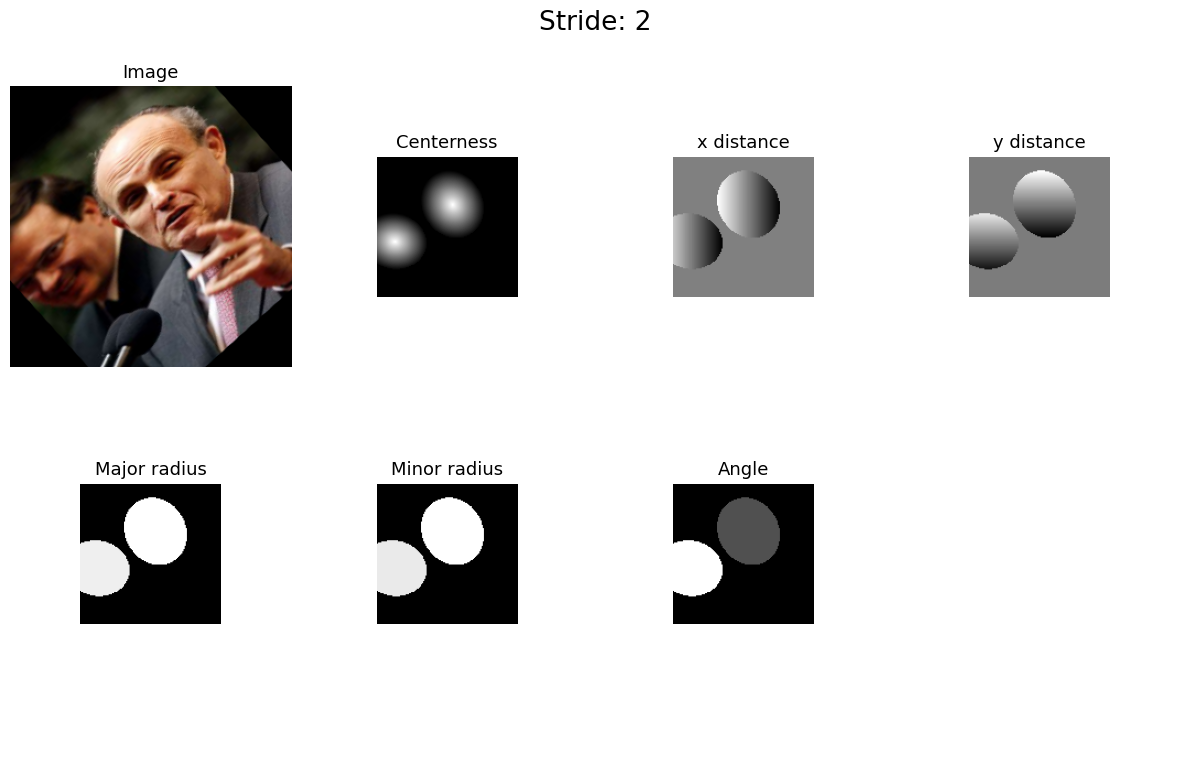

In [8]:
class CustomDataset(Dataset):
    def __init__(self, fp_imgs, annotations, resized_dims, strides,
                 area_limits):
        self.fp_imgs = fp_imgs
        self.annotations = annotations
        self.resized_dims = resized_dims
        self.strides = strides
        self.area_limits = area_limits

    def __len__(self):
        return len(self.fp_imgs)

    def __getitem__(self, idx):
        fp_img = self.fp_imgs[idx]
        img = np.array(Image.open(fp_img)) / 255
        ellipse_pars = self.annotations[fp_img]

        img_aug, ellipse_pars_aug = resize_img_and_annotation(
            img, ellipse_pars, self.resized_dims)

        # Create mask
        masks = create_masks(
            img_aug, ellipse_pars_aug, self.strides, self.area_limits)

        img_aug = torch.moveaxis(torch.tensor(
            img_aug, dtype=torch.float32), 2, 0)
        masks = [torch.tensor(x, dtype=torch.float32) for x in masks]
        return img_aug, masks


ds_train = CustomDataset(
    fp_imgs_train, annotations, resized_dims, strides_fpn_out, area_limits)
ds_val = CustomDataset(
    fp_imgs_val, annotations, resized_dims, strides_fpn_out, area_limits)
ds_test = CustomDataset(
    fp_imgs_test, annotations, resized_dims, strides_fpn_out, area_limits)

loader_train = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(
    ds_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(
    ds_test, batch_size=batch_size, shuffle=False)

idx0 = 10

img0, mask0 = ds_train[idx0]
img0 = np.moveaxis(img0.numpy(), 0, 2)

for idx1, mask in enumerate(mask0):
    stride = strides_fpn_out[idx1]
    fig, ax = plt.subplots(2, 4, figsize=(12, 8))
    ax[0, 0].imshow(img0)
    ax[0, 0].set_title("Image", fontsize=13)

    ax[0, 1].imshow(mask[0].numpy(), cmap="gray")
    ax[0, 1].set_title("Centerness", fontsize=13)
    ax[0, 1].set_box_aspect((1/stride))

    ax[0, 2].imshow(mask[1].numpy(), cmap="gray")
    ax[0, 2].set_title("x distance", fontsize=13)
    ax[0, 2].set_box_aspect((1/stride))

    ax[0, 3].imshow(mask[2].numpy(), cmap="gray")
    ax[0, 3].set_title("y distance", fontsize=13)
    ax[0, 3].set_box_aspect((1/stride))

    ax[1, 0].imshow(mask[3].numpy(), cmap="gray")
    ax[1, 0].set_title("Major radius", fontsize=13)
    ax[1, 0].set_box_aspect((1/stride))

    ax[1, 1].imshow(mask[4].numpy(), cmap="gray")
    ax[1, 1].set_title("Minor radius", fontsize=13)
    ax[1, 1].set_box_aspect((1/stride))

    ax[1, 2].imshow(mask[5].numpy(), cmap="gray")
    ax[1, 2].set_title("Angle", fontsize=13)
    ax[1, 2].set_box_aspect((1/stride))

    [axi.set_axis_off() for axi in ax.ravel()]
    fig.suptitle(f"Stride: {stride}", fontsize=19, y=0.95)
    plt.tight_layout()
    plt.show()

Now we work on our loss function. For the centerness mask, we can simply use binary cross entropy. For the ellipse parameters, we will use Kullback-Leibler divergence. The corresponding functions *ellipse_pars_to_gauss_dist* and *calc_kld_loss* are taken from the MMRotate package (https://github.com/open-mmlab/mmrotate/blob/main/mmrotate/models/losses/gaussian_dist_loss.py) and are licensed under the Apache License 2.0.

In [9]:
def ellipse_pars_to_gauss_dist(ellipse_pars):
    # https://github.com/open-mmlab/mmrotate/blob/main/mmrotate/models/losses/gaussian_dist_loss.py

    _shape = ellipse_pars.shape
    assert _shape[-1] == 5
    xy = ellipse_pars[..., 0:2]
    wh = ellipse_pars[..., 2:4].clamp(min=1e-6).reshape(-1, 2)
    r = ellipse_pars[..., 4]
    cos_r = torch.cos(r)
    sin_r = torch.sin(r)
    R = torch.stack((cos_r, -sin_r, sin_r, cos_r), dim=-1).reshape(-1, 2, 2)
    S = 0.5 * torch.diag_embed(wh)

    sigma = R.bmm(
        S.square()).bmm(R.permute(0, 2, 1)).reshape(_shape[:-1] + (2, 2))
    return xy, sigma


def calc_kld_loss(pred, target, fun, tau=1.0):
    # https://github.com/open-mmlab/mmrotate/blob/main/mmrotate/models/losses/gaussian_dist_loss.py
    mu_p, sigma_p = pred
    mu_t, sigma_t = target

    mu_p = mu_p.reshape(-1, 2)
    mu_t = mu_t.reshape(-1, 2)
    sigma_p = sigma_p.reshape(-1, 2, 2)
    sigma_t = sigma_t.reshape(-1, 2, 2)

    delta = (mu_p - mu_t).unsqueeze(-1)
    sigma_t_inv = torch.inverse(sigma_t)
    term1 = delta.transpose(
        -1, -2).matmul(sigma_t_inv).matmul(delta).squeeze(-1)
    term2 = torch.diagonal(
        sigma_t_inv.matmul(sigma_p),
        dim1=-2, dim2=-1).sum(dim=-1, keepdim=True) + \
        torch.log(torch.det(sigma_t) / torch.det(sigma_p)).reshape(-1, 1)
    dis = term1 + term2 - 2
    kl_dis = dis.clamp(min=1e-6)

    if fun == "sqrt":
        kl_loss = 1 - 1 / (tau + torch.sqrt(kl_dis))
    else:
        kl_loss = 1 - 1 / (tau + torch.log1p(kl_dis))
    return kl_loss


def composite_loss(preds, gts, strides, weights, fun):
    centerness_loss = torch.tensor(0, dtype=torch.float32).to(device)
    kld_loss = torch.empty((0, 1), dtype=torch.float32).to(device)

    for idx, (pred, gt) in enumerate(zip(preds, gts)):
        centerness_loss += F.binary_cross_entropy(
           pred[:, 0, :, :], gt[:, 0, :, :])

        # KLD loss
        to_keep = torch.where(
            torch.flatten(
                gt[:, 0, :, :].clone(), start_dim=1).reshape(-1) > 0.0,
            True, False).to(device)
        coords_all = torch.stack(torch.meshgrid(
            torch.arange(
                strides[idx]//2, gt.shape[2] * strides[idx], strides[idx]),
            torch.arange(
                strides[idx]//2, gt.shape[3] * strides[idx], strides[idx]),
            indexing="xy")).reshape((2, -1)).mT.to(device)

        pred_ellipse_pars = torch.flatten(
            pred[:, 1:, :, :].clone(), start_dim=2).permute(0, 2, 1)
        pred_ellipse_pars[:, :, 0:2] = coords_all + pred_ellipse_pars[:, :, 0:2]
        pred_ellipse_pars = pred_ellipse_pars.reshape((-1, 5))
        pred_ellipse_pars = pred_ellipse_pars[torch.where(to_keep)]

        gt_ellipse_pars = torch.flatten(
            gt[:, 1:, :, :].clone(), start_dim=2).permute(0, 2, 1)
        gt_ellipse_pars[:, :, 0:2] = coords_all + gt_ellipse_pars[:, :, 0:2]
        gt_ellipse_pars = gt_ellipse_pars.reshape((-1, 5))
        gt_ellipse_pars = gt_ellipse_pars[torch.where(to_keep)]

        pred_gauss_dist = ellipse_pars_to_gauss_dist(pred_ellipse_pars)
        gt_gauss_dist = ellipse_pars_to_gauss_dist(gt_ellipse_pars)

        kld_loss_temp = calc_kld_loss(pred_gauss_dist, gt_gauss_dist, fun)
        kld_loss = torch.vstack((kld_loss, kld_loss_temp))

    # In case there are no objects in a batch
    if kld_loss.shape[0] == 0:
        kld_loss = torch.tensor(0, dtype=torch.float32)
    else:
        kld_loss = torch.mean(kld_loss)

    return (
        (centerness_loss / (idx + 1)) * weights[0],
        kld_loss * weights[1])

Now, let's define our FCOS model architecture:

In [10]:
class Residual(nn.Module):
    def __init__(self, filters_in, filters_out, contract=False):
        super().__init__()
        self.bn1 = BatchNorm2d(filters_in)
        self.bn2 = BatchNorm2d(filters_out//2)
        self.bn3 = BatchNorm2d(filters_out//2)
        self.activation = ReLU()
        self.conv1 = Conv2d(
            in_channels=filters_in, out_channels=filters_out,
            kernel_size=1, stride=1, padding=0)
        self.conv2 = Conv2d(
            in_channels=filters_in, out_channels=filters_out//2,
            kernel_size=1, stride=1, padding=0)
        self.conv3 = Conv2d(
            in_channels=filters_out//2, out_channels=filters_out//2,
            kernel_size=3, stride=1, padding=1)
        self.conv4 = Conv2d(
            in_channels=filters_out//2, out_channels=filters_out,
            kernel_size=1, stride=1, padding=0)

        self.contract = contract
        self.pooling = MaxPool2d((2, 2))

    def forward(self, x):
        if self.contract:
            x = self.pooling(x)

        x = self.bn1(x)
        x = self.activation(x)
        x_skip = self.conv1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)

        x = self.conv4(x)
        x = x_skip + x
        return x


class BackboneModel(nn.Module):
    def __init__(self, filters_init_backbone, strides, input_shape):
        super().__init__()
        self.strides = strides
        self.filters = [filters_init_backbone*2**x for x in
                        list(range(0, int(math.log2(self.strides[-1])) + 1))]
        self.filters.insert(0, input_shape[0])

        self.layers = nn.ModuleList()
        for idx, _ in enumerate(self.filters[:-1]):
            # No pooling for first layer
            contract = False if idx==0 else True

            self.layers.append(
                Residual(
                    self.filters[idx], self.filters[idx+1], contract=contract))

    def forward(self, x):
        out = []
        for idx, layer in enumerate(self.layers):
            x = self.layers[idx](x)
            if 2**idx in self.strides:
                out.append(x)
        return out[::-1]


class FeaturePyramid(nn.Module):
    def __init__(self, filters_fpn, filters_init_backbone, strides_fpn_in,
                 strides_fpn_out):
        super().__init__()
        self.strides_fpn_in = strides_fpn_in
        self.strides_fpn_out = strides_fpn_out

        self.upsample = Upsample(scale_factor=2, mode="bilinear")
        self.pool = MaxPool2d((2, 2))
        self.con_in = nn.ModuleList(
            [Conv2d(f_in, filters_fpn, 1) for f_in in
             [x * filters_init_backbone for x in self.strides_fpn_in[::-1]]])

        self.fpn = nn.ModuleList(
            [Residual(filters_fpn, filters_fpn, contract=False) for _ in
             range(len(strides_fpn_in))])

    def forward(self, inputs):
        inputs_proc = []
        for idx, x in enumerate(inputs):
            inputs_proc.append(self.con_in[idx](x))

        outputs = []
        for idx, x in enumerate(inputs_proc):
            if idx == 0:
                outputs.append(self.fpn[idx](x))
            else:
                outputs.append(self.fpn[idx](x + self.upsample(outputs[-1])))

        idx_out = [
            self.strides_fpn_in[::-1].index(x) for x in self.strides_fpn_out]
        outputs = [outputs[x] for x in idx_out]
        return outputs


class Scaler(nn.Module):
    def __init__(self, init=1.0):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor([init], dtype=torch.float32))

    def forward(self, x):
        return x * self.scale


class DetectionHead(nn.Module):
    def __init__(self, filters_fpn, num_convs, strides_fpn_out):
        super().__init__()
        self.strides = strides_fpn_out

        self.cls_branch = nn.Sequential(
            *[Residual(filters_fpn, filters_fpn, contract=False) for _ in
              range(num_convs)])
        self.centerness = Conv2d(
            in_channels=filters_fpn, out_channels=1, kernel_size=3, stride=1,
            padding=1)
        self.sigmoid = Sigmoid()
        self.relu = ReLU(inplace=False)

        self.ellipse_branch = nn.Sequential(
            *[Residual(filters_fpn, filters_fpn, contract=False) for _ in
              range(num_convs)])

        self.xc, self.yc, self.w, self.h, self.alpha = [
            Conv2d(in_channels=filters_fpn, out_channels=1, kernel_size=3,
                   stride=1, padding=1) for _ in range(5)]

        self.scale = nn.ModuleList(
            [Scaler(1.0) for _ in range(len(self.strides))])

    def forward(self, inputs):
        outputs = []

        for idx, z in enumerate(inputs):
            out = torch.zeros(
                (z.shape[0], 6, z.shape[2], z.shape[3])).to(device)

            z0 = self.cls_branch(z)
            out[:, 0:1, :, :] = self.sigmoid(self.centerness(z0)) # centerness

            z1 = self.ellipse_branch(z)
            out[:, 1:2, :, :] = self.scale[idx](self.xc(z1))
            out[:, 2:3, :, :] = self.scale[idx](self.yc(z1))
            out[:, 3:4, :, :] = self.relu(self.scale[idx](self.w(z1))) + 1
            out[:, 4:5, :, :] = self.relu(self.scale[idx](self.h(z1))) + 1
            out[:, 5:, :, :] = self.alpha(z1) # alpha, restrict range to 0-180°
            outputs.append(out)
        return outputs


class FCOS(nn.Module):
    def __init__(self, filters_init_backbone, strides_fpn_in, strides_fpn_out,
                 input_shape, filters_fpn, num_detection_head_convs):
        super().__init__()
        self.backbone = BackboneModel(
            filters_init_backbone, strides_fpn_in, input_shape)
        self.fpn = FeaturePyramid(
            filters_fpn, filters_init_backbone, strides_fpn_in, strides_fpn_out)
        self.head = DetectionHead(
            filters_fpn, num_detection_head_convs, strides_fpn_out)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fpn(x)
        x = self.head(x)
        return x

Some custom learning rate scheduler:

In [11]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
    def __init__(self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min,
                 warmup_epochs, f_reduction, f_restart, patience,
                 min_loss_improvement, no_of_restarts_init,
                 increment_no_of_restarts):
        self.optimizer = optimizer
        self.lr_after_warmup = lr_after_warmup
        self.lr_decay = lr_decay
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.f_reduction = f_reduction
        self.f_restart = f_restart
        self.patience = patience
        self.min_loss_improvement = min_loss_improvement
        self.no_of_restarts_init = no_of_restarts_init
        self.increment_no_of_restarts = increment_no_of_restarts

        self.loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False
        self.set_par("initial_lr", self.lr_min)
        self.set_par("lr", self.lr_min)
        self.epoch = 0

    def get_par(self, name):
        for group in self.optimizer.param_groups: par = group[name]
        return par

    def set_par(self, name, value):
        for group in self.optimizer.param_groups: group[name] = value

    def on_loss_improvement(self, loss_cur):
        self.loss_best = loss_cur
        self.plateau_epochs = 0

    def on_loss_deterioration(self):
        self.plateau_epochs += 1

    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay

    def on_plateau(self, lr):
        if self.reductions_counter >= self.no_of_restarts_init:
            lr_new = self.restart_lr()
        else:
            lr_new = self.steep_reduce_lr(lr)
        return lr_new

    def steep_reduce_lr(self, lr):
        lr_new = lr * self.f_reduction
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new

    def restart_lr(self):
        self.lr_after_warmup *= self.f_restart
        lr_new = self.lr_after_warmup
        if lr_new > self.lr_max:
            lr_new = self.lr_max
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.no_of_restarts_init += self.increment_no_of_restarts
        self.just_restarted = True
        return lr_new

    def warmup(self):
        lr_new = self.lr_min + (self.lr_after_warmup - self.lr_min) * (
            self.epoch / self.warmup_epochs)
        return lr_new

    def step(self, metrics):
        if self.epoch <= self.warmup_epochs:
            lr_new = self.warmup()
        else:
            lr_cur = self.get_par("lr")
            loss_cur = float(metrics)

            if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
                self.on_loss_improvement(loss_cur)
            else:
                self.on_loss_deterioration()
            lr_new = self.multiplicative_decay_lr(lr_cur)

            if self.just_restarted:
                self.loss_best = loss_cur
                self.just_restarted = False

            if self.plateau_epochs >= self.patience:
                lr_new = self.on_plateau(lr_cur)

            if lr_new <= self.lr_min:
                lr_new = self.restart_lr()

        self.set_par("lr", lr_new)
        self.epoch += 1

And finally our Pytorch Lightning module for training which we will subsequently start:

In [12]:
cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(save_dir="logs/", name="model001",
                    flush_logs_every_n_steps=1)


class FCOSModule(pl.LightningModule):
    def __init__(self, filters_init_backbone, strides_fpn_in, strides_fpn_out,
                 input_shape, filters_fpn,
                 num_detection_head_convs, loss_weights):
        super().__init__()
        self.automatic_optimization = False
        self.fcos = FCOS(
            filters_init_backbone, strides_fpn_in, strides_fpn_out,
             input_shape, filters_fpn, num_detection_head_convs)

        self.strides = strides_fpn_out
        self.loss_weights = loss_weights

    def forward(self, x):
        x = self.fcos(x)
        return x

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)

        centerness_loss, kld_loss = composite_loss(
                y_pred, y, self.strides, self.loss_weights, fun="log1p")
        loss = centerness_loss + kld_loss

        # For logging loss & metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True,
                 prog_bar=True)
        self.log("train_centerness_loss", centerness_loss, on_step=False,
                 on_epoch=True, prog_bar=True)
        self.log("train_kld_loss", kld_loss, on_step=False, on_epoch=True,
                 prog_bar=True)

        self.manual_backward(loss)
        opt.step()
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)

        centerness_loss, kld_loss = composite_loss(
                y_pred, y, self.strides, self.loss_weights, fun="log1p")
        loss = centerness_loss + kld_loss

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_centerness_loss", centerness_loss, on_step=False,
                 on_epoch=True, prog_bar=True)
        self.log("val_kld_loss", kld_loss, on_step=False, on_epoch=True,
                 prog_bar=True)

        if batch_idx == 0:
            self.cur_val_loss = []
        self.cur_val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay,
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience,
            min_loss_improvement=min_loss_improvement,
            no_of_restarts_init=no_of_restarts_init,
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


model001 = FCOSModule(
    filters_init_backbone, strides_fpn_in, strides_fpn_out,
    (img_channels,) + resized_dims, filters_fpn,
    num_detection_head_convs, loss_weights)

trainer1a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1,
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1,
    devices=1, enable_progress_bar=False, accelerator="gpu")

trainer1a.fit(
    model=model001, train_dataloaders=loader_train, val_dataloaders=loader_val)

Let's visualize the training progress:

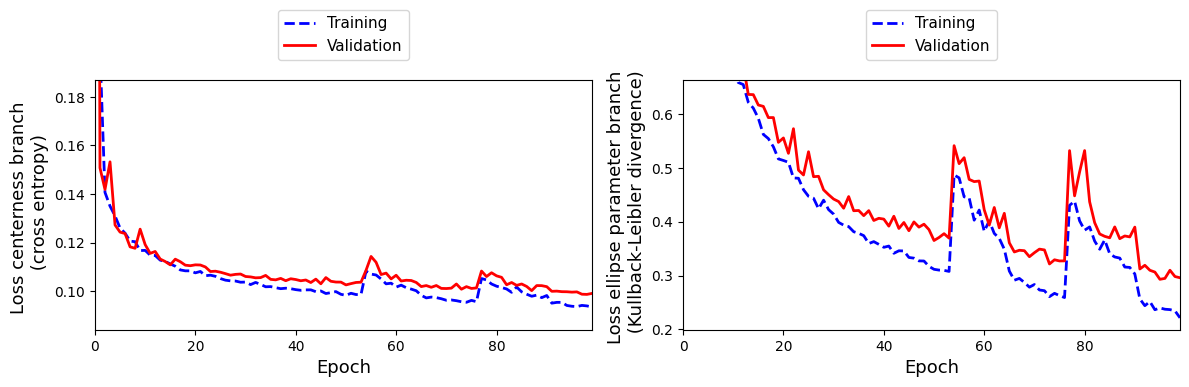

In [13]:
logs = pd.read_csv(pathlib.Path(trainer1a.logger.log_dir + "/metrics.csv"))

epochs = logs["epoch"][1::3]

fig1, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
l1 = ax0.plot(
    epochs, logs["train_centerness_loss"][2::3],
    color="b", linewidth=2, linestyle="dashed", label="Training")
l2 = ax0.plot(
    epochs, logs["val_centerness_loss"][1::3],
    color="r", linewidth=2, label="Validation")
ax0.set_xlabel("Epoch", fontsize=13)
ax0.set_ylabel("Loss centerness branch \n (cross entropy)", fontsize=13)
ax0.set_xlim(0, len(epochs) - 1)
min_centerness_loss = min(
    np.concatenate((
        logs["train_centerness_loss"][2::3].to_numpy(),
        logs["val_centerness_loss"][1::3].to_numpy()
        )
    )
)
ax0.set_ylim(min_centerness_loss*0.9, min_centerness_loss*2)
ax0.legend(l1+l2, [l.get_label() for l in l1+l2], loc="lower center",
           bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=1, fontsize=11)

l3 = ax1.plot(
    epochs, logs["train_kld_loss"][2::3], color="b",
    linewidth=2, linestyle="dashed", label="Training")
l4 = ax1.plot(
    epochs, logs["val_kld_loss"][1::3], color="r",
    linewidth=2, label="Validation")
ax1.set_xlabel("Epoch", fontsize=13)
ax1.set_ylabel("Loss ellipse parameter branch \n (Kullback-Leibler divergence)",
               fontsize=13)
ax1.set_xlim(0, len(epochs) - 1)
min_kld_loss = min(
    np.concatenate((
        logs["train_kld_loss"][2::3].to_numpy(),
        logs["val_kld_loss"][1::3].to_numpy()
        )
    )
)
ax1.set_ylim(min_kld_loss*0.9, min_kld_loss*3)
ax1.legend(l3+l4, [l.get_label() for l in l3+l4], loc="lower center",
           bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=1, fontsize=11)
plt.tight_layout()
plt.show()

We will reload our best model from checkpoint and export this model to ONNX format so that the we can from now on use the model to predict independently of Pytorch:

In [14]:
model002 = FCOSModule(
    filters_init_backbone, strides_fpn_in, strides_fpn_out,
    (img_channels,) + resized_dims, filters_fpn,
    num_detection_head_convs, loss_weights)

checkpoint_file = trainer1a.checkpoint_callback.best_model_path

model002 = model002.load_from_checkpoint(
    checkpoint_file, filters_init_backbone=filters_init_backbone,
    strides_fpn_in=strides_fpn_in, strides_fpn_out=strides_fpn_out,
    input_shape=(img_channels,) + resized_dims, filters_fpn=filters_fpn,
    num_detection_head_convs=num_detection_head_convs,
    loss_weights=loss_weights)

model002 = model002.fcos
model002.eval()

img_dummy = torch.zeros((1, img_channels,) + resized_dims).to(device)
torch.onnx.export(
    model=model002, args=img_dummy, f="onnx_model.onnx", export_params=True,
    opset_version=13, do_constant_folding=True, input_names = ["input"],
    output_names = ["output"], dynamic_axes={"input": {0 : "batch_size"},
                                             "output": {0 : "batch_size"}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Let's look at an exemplary model output from an image from the test data:

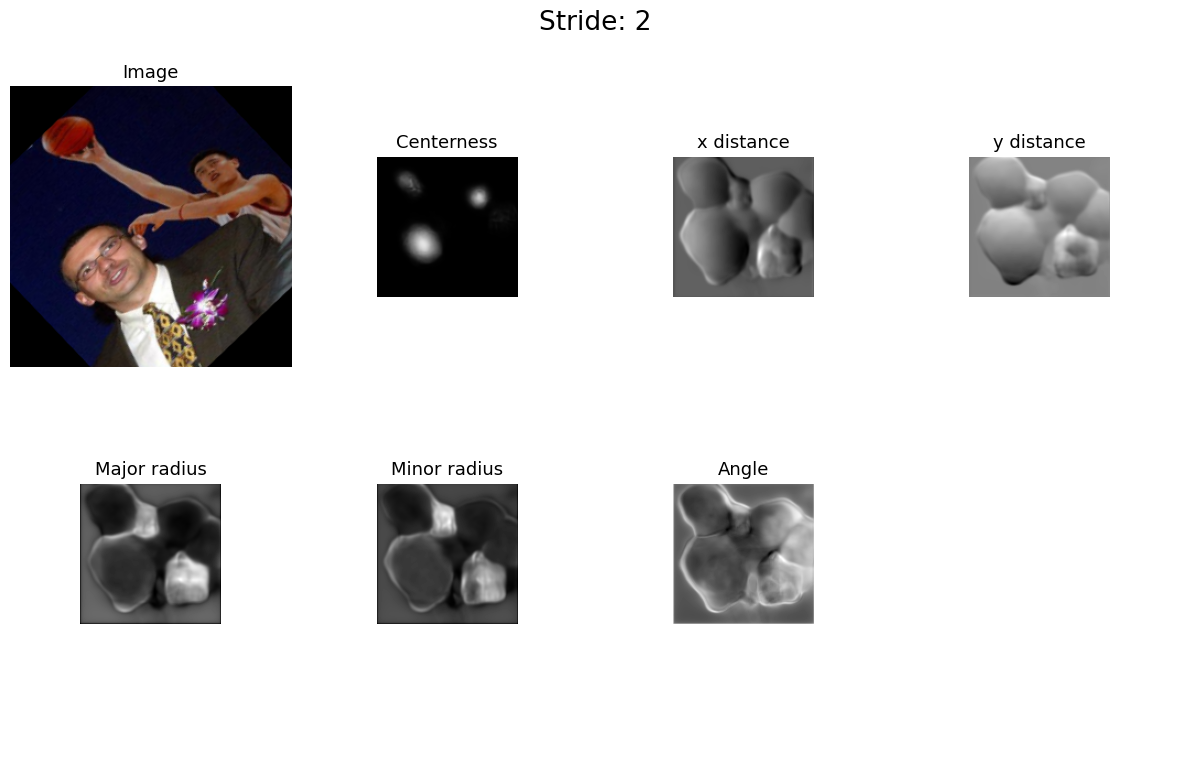

In [15]:
img1, mask_true1 = ds_test[12]
img1 = img1[None, :, :, :].numpy()

ort_session = onnxruntime.InferenceSession("onnx_model.onnx", providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: img1}
mask1_pred = ort_session.run(None, ort_inputs)

for idx1, mask in enumerate(mask1_pred):
    stride = strides_fpn_out[idx1]
    fig, ax = plt.subplots(2, 4, figsize=(12, 8))
    ax[0, 0].imshow(np.moveaxis(img1[0, :, :, :], 0, 2))
    ax[0, 0].set_title("Image", fontsize=13)

    ax[0, 1].imshow(mask[0, 0, :, :], cmap="gray", vmin=0, vmax=1)
    ax[0, 1].set_title("Centerness", fontsize=13)
    ax[0, 1].set_box_aspect((1/stride))

    ax[0, 2].imshow(mask[0, 1, :, :], cmap="gray")
    ax[0, 2].set_title("x distance", fontsize=13)
    ax[0, 2].set_box_aspect((1/stride))

    ax[0, 3].imshow(mask[0, 2, :, :], cmap="gray")
    ax[0, 3].set_title("y distance", fontsize=13)
    ax[0, 3].set_box_aspect((1/stride))

    ax[1, 0].imshow(mask[0, 3, :, :], cmap="gray")
    ax[1, 0].set_title("Major radius", fontsize=13)
    ax[1, 0].set_box_aspect((1/stride))

    ax[1, 1].imshow(mask[0, 4, :, :], cmap="gray")
    ax[1, 1].set_title("Minor radius", fontsize=13)
    ax[1, 1].set_box_aspect((1/stride))

    ax[1, 2].imshow(mask[0, 5, :, :], cmap="gray")
    ax[1, 2].set_title("Angle", fontsize=13)
    ax[1, 2].set_box_aspect((1/stride))

    [axi.set_axis_off() for axi in ax.ravel()]
    fig.suptitle(f"Stride: {stride}", fontsize=19, y=0.95)
    fig.tight_layout()
    plt.show()

Great. But after all, we came to predict rotated ellipses and not some masks. So, let's define our non-max suppression step. Classical non-max suppression uses a intersection-over-union cutoff value to decide wether or not to suppress. We will instead again use Kullback-Leibler divergence to make this decison. Because we are no longer working in Pytorch with our ONNX model, I "translated" the *ellipse_pars_to_gauss_dist* and *calc_kld_loss* functions from above to numpy:

In [16]:
def ellipse_pars_to_gauss_dist_np(ellipse_pars):
    _shape = ellipse_pars.shape
    assert _shape[-1] == 5
    xy = ellipse_pars[:, 0:2]
    wh = ellipse_pars[:, 2:4].clip(min=1e-7, max=None).reshape(-1, 2)
    r = ellipse_pars[:, 4]
    cos_r = np.cos(r)
    sin_r = np.sin(r)
    R = np.stack([cos_r, -sin_r, sin_r, cos_r], axis=-1).reshape(-1, 2, 2)
    S = 0.5 * np.stack([np.diag(x) for x in wh])

    sigma = np.matmul(np.matmul(R, np.square(S)),
                      np.transpose(R, (0, 2, 1))).reshape(_shape[:-1] + (2, 2))
    return xy, sigma


def calc_kld_loss_np(pred, target, fun="log1p", tau=1.0):
    mu_p, sigma_p = pred
    mu_t, sigma_t = target

    mu_p = mu_p.reshape(-1, 2)
    mu_t = mu_t.reshape(-1, 2)
    sigma_p = sigma_p.reshape(-1, 2, 2)
    sigma_t = sigma_t.reshape(-1, 2, 2)

    delta = np.expand_dims(mu_p - mu_t, 2)
    sigma_t_inv = np.linalg.inv(sigma_t)
    term1 = np.matmul(np.transpose(delta, (0, 2, 1)),
                      np.matmul(sigma_t_inv, delta)).squeeze(-1)
    term2 = np.sum(
        np.diagonal(np.matmul(sigma_t_inv, sigma_p), axis1=-2, axis2=-1),
        axis=-1, keepdims=True) + np.log(np.linalg.det(
            sigma_t) / np.linalg.det(sigma_p)).reshape(-1, 1)
    dis = term1 + term2 - 2
    kl_dis = np.clip(dis, a_min=1e-6, a_max=None)

    if fun == "sqrt":
        kl_loss = 1 - 1 / (tau + np.sqrt(kl_dis))
    else:
        kl_loss = 1 - 1 / (tau + np.log1p(kl_dis))
    return kl_loss


def nms(preds, strides, centerness_thresh=0.6, kld_thresh=0.2):
    pred_ellipse_pars_all = np.empty((0, 5), dtype=np.float32)
    centerness_all = np.empty((0), dtype=np.float32)

    for idx, pred in enumerate(preds):
        coords_all = np.transpose(np.array(np.meshgrid(
            np.arange(
                strides[idx]//2, pred.shape[2] * strides[idx], strides[idx]),
            np.arange(
                strides[idx]//2, pred.shape[3] * strides[idx], strides[idx]),
            )).reshape(2, -1))

        pred_ellipse_pars = np.moveaxis(
            pred[:, 1:, :, :].reshape(*pred[:, 1:, :, :].shape[:-2], -1), 1, 2)

        pred_ellipse_pars[:, :, 0:2] = coords_all + pred_ellipse_pars[:, :, 0:2]
        pred_ellipse_pars = pred_ellipse_pars.reshape((-1, 5))

        centerness = pred[:, 0, :, :].flatten()
        pred_ellipse_pars_all = np.concatenate(
            (pred_ellipse_pars_all, pred_ellipse_pars))
        centerness_all = np.concatenate((centerness_all, centerness))

    sort_idx = np.argsort(centerness_all)[::-1]
    centerness_all_sorted = centerness_all[sort_idx]

    pred_ellipse_pars_all = pred_ellipse_pars_all[sort_idx][
        centerness_all_sorted > centerness_thresh]

    if pred_ellipse_pars_all.shape[0] > 0:
        gauss_dist_xy, gauss_dist_sigma = ellipse_pars_to_gauss_dist_np(
            pred_ellipse_pars_all)

        # Non max suppression
        nms_mask = np.ones(pred_ellipse_pars_all.shape[0], dtype=bool)
        for idx1 in range(gauss_dist_xy.shape[0]):
            if nms_mask[idx1] == True:
                for idx2 in range(idx1+1, gauss_dist_xy.shape[0]):
                    if nms_mask[idx2] == True:
                        score = calc_kld_loss_np(
                            (gauss_dist_xy[idx1], gauss_dist_sigma[idx1]),
                            (gauss_dist_xy[idx2], gauss_dist_sigma[idx2]))
                        if score < kld_thresh:
                            nms_mask[idx2] = False

        return pred_ellipse_pars_all[np.where(nms_mask)]
    else:
        return np.empty((0, 5), dtype=np.float32)

Now, we want to see our non-max suppression function in action:

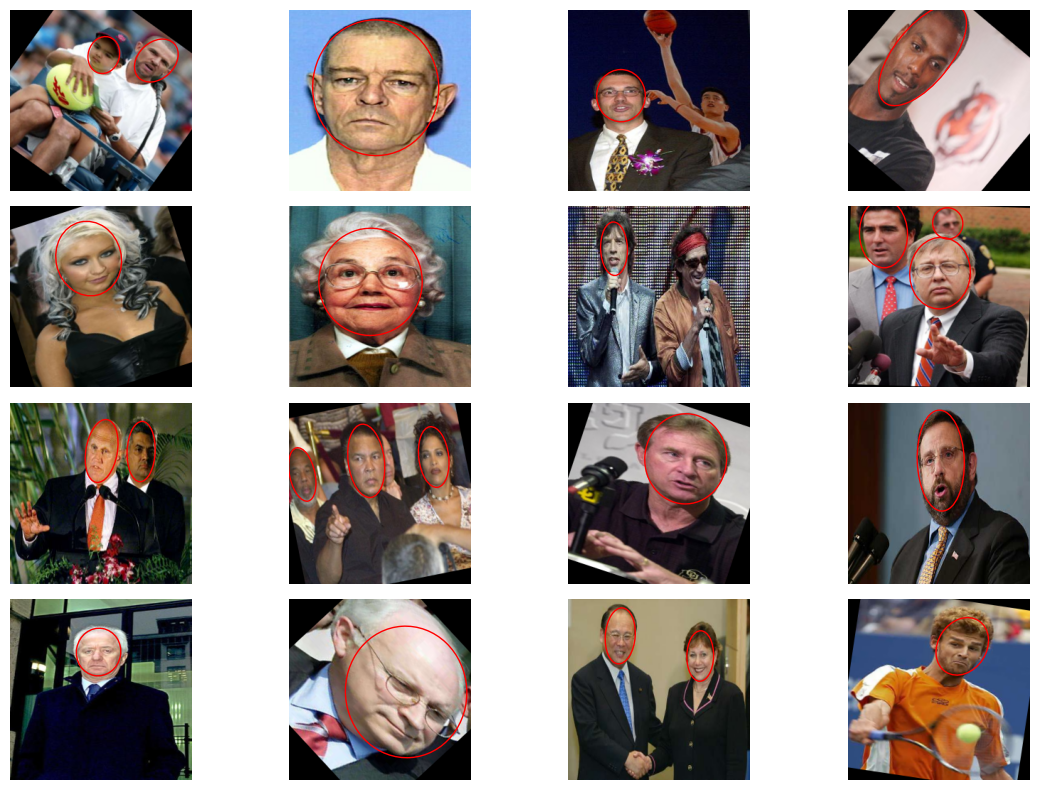

In [18]:
idxs = list(range(10, 26))

fig, ax = plt.subplots(4, 4, figsize=(12, 8))

for idx_loop, idx_img in enumerate(idxs):
    img, mask_true = ds_test[idx_img]
    ort_inputs = {ort_session.get_inputs()[0].name: img[None, :, :, :].numpy()}
    mask_pred = ort_session.run(None, ort_inputs)

    mask_proc = nms(
        mask_pred, strides_fpn_out, centerness_thresh=centerness_thresh,
        kld_thresh=kld_thresh)

    row = math.floor(idx_loop / 4)
    column = idx_loop - row * 4
    ax[row, column].imshow(np.moveaxis(img.numpy(), 0, 2))
    for ellipse_pars in mask_proc:
        e1 = Ellipse(
            (ellipse_pars[0], ellipse_pars[1]), ellipse_pars[2] * 2,
            ellipse_pars[3] * 2, angle=np.rad2deg(ellipse_pars[4]), linewidth=1,
            fill=False, color="red")
        ax[row, column].add_patch(e1)

[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
plt.show()

Not too bad, but also still room for improvement.